# From kernel string to structure drawing

### Task & Goal

### Steps
EXTRACT INFORMATION FROM STRING  
DETERMINE STRUCTURE  
DRAW SHAPES  

In [1]:
import re

import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from shapely.geometry.polygon import LinearRing

import drawSvg as draw

C:\Anaconda3\lib\site-packages\drawSvg\raster.py:18: RuntimeWarning: Failed to import CairoSVG. drawSvg will be unable to output PNG or other raster image formats. See https://github.com/cduck/drawSvg#prerequisites for more details.
Original OSError: no library called "cairo-2" was found
no library called "cairo" was found
cannot load library 'C:\GTK\bin\libcairo-2.dll': error 0xc1
cannot load library 'libcairo.so.2': error 0x7e
cannot load library 'libcairo.2.dylib': error 0x7e
cannot load library 'libcairo-2.dll': error 0xc1
  warnings.warn(msg, RuntimeWarning)


Error handling 1  
- invalid strings should not be let through  
- extra whitespaces or missing ones corrected before next step

## EXTRACT INFORMATION FROM STRING

First, count domains and create a table that has nrow corresponding to dom. count. As the string is very systematic, with a regional expression I can separate the domains with all their information given.  
The good thing here is that the sequence of domains is clear from the string.  
Most important is to know which domain is paired with which. As a human, when I find a bracket in the string, I look for its counterpart. This will have to be done in the second step and put the pairing info into a dictionary(?).

In [2]:
def comprehend_string(string):
    """
    
    table(int) - cols: angle before dom, length, dom type?, if there is a strand break after  
    dictionary - pairedness  
    list of list - name of domains, their preliminary type 
    """
    #separate domains/count
    pattern = re.compile('@?-?[0-9]* ?[a-z|A-Z|0-9|\*|\)]+[ \(]? ?\+?|\) ?\+?')
    dom_raw_list = pattern.findall(string)
    dom_count = len(dom_raw_list)
        
    #create empty data structures     
    struct_info_array = np.zeros((dom_count, 2), dtype = 'int') #3 cols rn, sb not needed here
    #empty angles indicated by -999
    for row in range(dom_count):
        struct_info_array[row, 0] = -999
    name_list1 = []
    
    #loop through the raw domains, extract  
    for dom_i in range(len(dom_raw_list)):
        dom = dom_raw_list[dom_i]
        dom = dom.strip()
        
        #fill table
        if re.search("\s", dom):
            dom_parts = re.split("\s", dom)
            
            for segm in dom_parts:
                if segm[0] is "@": #col0 angle
                    segm = segm.lstrip("@")
                    struct_info_array[dom_i, 0] = int(segm) #col0 to write to
                    #struct_info_array[dom_i, 1] = np.sign(int(segm)) #col1 to write to
                    
                #elif segm is "+": #col2 strand break
                #    struct_info_array[dom_i, 2] = 1         #col2 to write to
                elif segm is not "+": #else:
                    name_list1.append(segm) #only keep the name part further
        else:
            name_list1.append(dom)
        
    #pairedness dictionary
    paired_dict = {}
    
    for dom_i2 in range(len(dom_raw_list)):
        if re.search("\(", dom_raw_list[dom_i2]):
            bracket_count = 1
            for next_dom in range(dom_i2+1, len(dom_raw_list)):
                if re.search("\(", dom_raw_list[next_dom]):
                    bracket_count += 1
                elif re.search("\)", dom_raw_list[next_dom]):
                    bracket_count -= 1
                if bracket_count == 0:
                    paired_dict[dom_i2] = next_dom
                    break
    
    #name list of list / finding hairpin loops
    #paireds in dict, hairpin loop known, other are unpaired -> substructure from these?
    name_final_lol = []
    
    for dom_i3 in range(len(name_list1)):
        
        #paireds
        if re.search("\(", name_list1[dom_i3]):
            typ = "paired"
            name = name_list1[dom_i3].strip("(+ ")
        
        #correcting closing bracket name
        elif re.search("\)", name_list1[dom_i3]):
            typ = "paired"
            index_of_pair = list(paired_dict.keys())[list(paired_dict.values()).index(dom_i3)]
            if re.search("\*", name_list1[index_of_pair]):
                name = name_list1[index_of_pair].strip("\(").strip("\*")
            else:
                name = name_list1[index_of_pair].strip("\(") + "*"
        
        #all other are unpaireds
        else:
            typ = "unpaired"
            name = name_list1[dom_i3].strip("+ ")
        
        name_final_lol.append([name, typ])
        
    return dom_raw_list, struct_info_array, paired_dict, name_final_lol

In [3]:
string = "a( + b( + @45 ) )"
comprehend_string(string)

(['a( +', ' b( +', '@45 ) ', ')'],
 array([[-999,    0],
        [-999,    0],
        [  45,    0],
        [-999,    0]]),
 {0: 3, 1: 2},
 [['a', 'paired'], ['b', 'paired'], ['b*', 'paired'], ['a*', 'paired']])

### Distance list process and merge

In [4]:
def process_length_input(struct_info_array, length_input_dict):
    zeros_list = [0 for i in range(len(struct_info_array[:,1]))]
    
    #put into list format and append list to struct_info_array as new col
    for length in length_input_dict:
        zeros_list[length] = length_input_dict[length]
        
    zeros_list = np.array(zeros_list).reshape((len(zeros_list), 1))
    struct_info_array = np.append(struct_info_array, zeros_list, axis=1)
        
    return struct_info_array

## DETERMINE STRUCTURE 

### 1a. Create domain node graph
Figure out if an unpaired region is from a special type - by making a network graph of the connected domains (either connected by sequence (red edge) or by pairedness (green edge)) we can find subgraphs that correspond to special domain structures that need to be handled differently.  

In [5]:
def create_skeleton(dom_raw_list, paired_dict, name_final_lol):
    #append edges to graph
    G = nx.Graph()
    
    for dom_to_dom in range(len(name_final_lol)-1):
        if re.search("\+", dom_raw_list[dom_to_dom]) is None:
            G.add_edge(dom_to_dom, dom_to_dom+1, color='r') #domains that have a connection point are conn. with red edge
    for pair in paired_dict:
        G.add_edge(pair, paired_dict[pair], color='g') #paired domains are connected with green edge
    
    return G

In [6]:
def draw_skeleton(G):
    pos = nx.kamada_kawai_layout(G)
    colors = [G[u][v]['color'] for u,v in G.edges()]
    plt.figure(figsize=(16,9))

    nx.draw_networkx(G, pos = pos, with_label = True, node_size=600,font_size=15, edge_color=colors, 
                     node_color='y', width=2)

### 1b. Determining unpaired domain types
Currently we check:   
hairpin loop: easy, its neighbors are paired  
unhinged: has only one neighbor domain - these will need extra care, especially ones resulting from strand break  
bulgeloop: cycles with odd nodes and only 1! unpaired dom always has the strictly taken 'bulge'  
multiloop: hard, as any number of unpaired doms can be connected with each other, only check r-g-r connection  
crossroad: if a cycle is larger or equal to 6 nodes and has no unpaired domains, it is a crossroad

nick - not tracked, but strand breaks will need much work in general

In [7]:
def ds1_find_type_of_unpaired_v2(G, paired_dict, name_final_lol):
    #index of ununpaireds - these don't need to be checked
    paired_node_list = []
    for node in paired_dict:
        paired_node_list.append(node)
        paired_node_list.append(paired_dict[node])
    
    #get unpaired too
    unpaired_node_list = []
    for node_index in range(len(name_final_lol)):
        if node_index not in paired_node_list:
            unpaired_node_list.append(node_index)
    
    #cycles of the skeleton graph
    cycle_list_G = nx.cycle_basis(G) #neat!
    multiloop_list = []
    crossroad_list = []
    
    #look through cycles, where 3cycles are hairpin, 5c. are bulge and longer ones nest multiloops
    for cycle in cycle_list_G:
        if len(cycle) == 3: #always hairpin
            for item in cycle:
                if item in unpaired_node_list:
                    name_final_lol[item][1] = "hairpin loop" #name altering
                    unpaired_node_list.remove(item) #trim unpaired list from known items
        elif len(cycle) > 3 & len(cycle) % 2 == 1: #current bulge def
            unpaired_here = []
            for item in cycle:
                if item in unpaired_node_list:
                    unpaired_here.append(item)
            if len(unpaired_here) == 1:
                name_final_lol[unpaired_here[0]][1] = "bulgeloop" #name altering
                unpaired_node_list.remove(unpaired_here[0]) #trim unpaired list from known items
         
        #find multiloops, the corresponding domains are their own list item in multiloop_list
        crossroad_tracker = True
        
        if len(cycle) >= 6:
            curr_multiloop = []
            for index in range(len(cycle)):
                if cycle[index] in unpaired_node_list:
                    crossroad_tracker = False
                    
                    if cycle[index-3] in unpaired_node_list :
                        connections = [n for n in G.edges.data(nbunch=cycle[index-1])]
                        for edge in connections:
                            #only need to check paired edge between these2
                            if edge[1] == cycle[index-2] and edge[2]['color'] is 'g': 
                                name_final_lol[cycle[index-3]][1] = "multiloop"
                                name_final_lol[cycle[index]][1] = "multiloop" #altering names
                                if cycle[index] not in curr_multiloop:
                                    curr_multiloop.append(cycle[index])
                                if cycle[index-3] not in curr_multiloop:
                                    curr_multiloop.append(cycle[index-3])
            if len(curr_multiloop) > 0:
                multiloop_list.append(curr_multiloop)
                for dom in curr_multiloop:
                    unpaired_node_list.remove(dom) #trim unpaired list from known items
            if crossroad_tracker is True: #if no unpaired region in cycle, it is a crossroad
                crossroad_list.append(cycle)
    
    #unhinged sequence
    for node_index in unpaired_node_list:
        #first neighbors
        direct_neigh = [n for n in G.neighbors(node_index)] #neighbors of current node
        
        #start from unhinged and go until all neighbors are unpaired
        if len(direct_neigh) == 1:
            name_final_lol[node_index][1] = "unhinged"
            
            next_neigh = direct_neigh
            before = [node_index]
            while len(next_neigh) == 1 and next_neigh[0] in unpaired_node_list:
                name_final_lol[next_neigh[0]][1] = "unhinged sequence"
                before.append(next_neigh[0])
                next_neigh = [n for n in G.neighbors(next_neigh[0])]
                next_neigh.remove(before[-2])
            for step in before:
                unpaired_node_list.remove(step) #bug with this line, cuts out 20 below, could implement it a bit diff
    
    #remaining is unknown but probably linear
    for remain in unpaired_node_list:
        name_final_lol[remain][1] = "ambiguous"
    
    return name_final_lol, multiloop_list, crossroad_list, cycle_list_G

### 2. Corresponding side determination

Side is an important property for a structure, especially for substructures and paired regions. For unpaired domains, it only determines the side its label is printed on, but for substructures, the side is uniform and it determines the 'rotation' one can walk through the loop (counter-clockwise/clockwise).  
Given angles determine the side for the substructure they are in, not the input values explicitly, but the transformed angles for the loop's polygon (more on that later). For  loops, concave angles can be given, but this fact have to be clear by giving angles from the concave interval ([360 - 181 or -359 - -181].  
Using these, all domains get a side property filled around the given info, if not provided, default is negative (-1) side.  

In [58]:
def ds2_fill_side_col(struct_info_array, cycle_list_G, name_final_lol):
    dom_count = len(struct_info_array[:,1])
    
    #we take side info from sign of rel.angle, not robust solution
    for row in range(dom_count):
        if struct_info_array[row, 0] != -999:
            if name_final_lol[row][1] is "bulgeloop": #special case for bulge :/
                struct_info_array[row, 1] = np.sign(int(struct_info_array[row, 0])*-1)
            else:
                struct_info_array[row, 1] = np.sign(int(struct_info_array[row, 0]))
    
    #first loop through cycles
    for cycle in cycle_list_G:
        sides_there = []
        for dom_cyc in cycle:
            sides_there.append(struct_info_array[dom_cyc, 1])
            
        #if 1 in sides_there and -1 in sides_there:
        #    raise ValueError(f'conflicting angles with domains of index: {cycle}')   #not how should be handled
        if -1 in sides_there:
            for dom_cyc in cycle:
                struct_info_array[dom_cyc, 1] = -1
        #pos substruc
        elif 1 in sides_there:
            for dom_cyc in cycle:
                struct_info_array[dom_cyc, 1] = 1
        #neg substruc or all 0
        else:
            for dom_cyc in cycle:
                struct_info_array[dom_cyc, 1] = 1
    
    #then remaining ones are just based on previous neighbor to look more homogenous
    for dom_index in range(dom_count):
        if struct_info_array[dom_index, 1] == 0: #don't change if already given side
                if dom_index == 0:
                    struct_info_array[0, 1] = -1
                else:
                    struct_info_array[dom_index, 1] = struct_info_array[dom_index-1, 1]
        
    return struct_info_array

def ds2_fill_side_col(struct_info_array, cycle_list_G, name_final_lol):
    dom_count = len(struct_info_array[:,1])
    
    paired_node_list = []
    for node in paired_dict:
        paired_node_list.append(node)
        paired_node_list.append(paired_dict[node])
    
    #we take side info from sign of rel.angle ~ transformed into polygon angle
    for row in range(dom_count):
        if struct_info_array[row, 0] != -999:
            #if dom in cycle, go through all tthese doms, get neighbor type
            #
            
    def feed_polyarr_to_structarray(struct_info_array, polygon_array, cycle, paired_node_list):
        """Write back calculated relative angles and domain lengths(if appropriate) to SIA"""
        
        for poly_index in range(len(polygon_array[:,0])):
            curr_dom_index = polygon_array[poly_index, 0]
            poly_ang = polygon_array[poly_index, 1]
            poly_len = polygon_array[poly_index, 2]
            
            side = struct_info_array[curr_dom_index, 1]
            cyc_index = cycle.index(curr_dom_index)
            
            if curr_dom_index not in paired_node_list: #at the start of an unpaired there is always a polygon angle
                struct_info_array[curr_dom_index, 2] = poly_len #if unpaired, the length we write over
                
                if cycle[cyc_index-1] not in paired_node_list: #unpaired-unpaired
                    rel_angle = (poly_ang - 180) / side
                    struct_info_array[curr_dom_index, 0] = rel_angle
                
                else:                                          #unpaired - paired(prev)
                    rel_angle = (poly_ang - 90) / side
                    struct_info_array[curr_dom_index, 0] = rel_angle
            
            else:
                if cycle[cyc_index - 1] not in paired_node_list: #paired-unpaired
                    rel_angle = (poly_ang - 90) / side
                    struct_info_array[curr_dom_index, 0] = rel_angle
                    
                else: #it is always the right paired-paired, as we only put those in the table
                    rel_angle = poly_ang*side
                    struct_info_array[curr_dom_index, 0] = rel_angle
        
        return struct_info_array
            
            
            ######################
            
            
            #if outside of cycle just take rel angle
                struct_info_array[row, 1] = np.sign(int(struct_info_array[row, 0]))

    #first loop through cycles
    for cycle in cycle_list_G:
        sides_there = []
        for dom_cyc in cycle:
            sides_there.append(struct_info_array[dom_cyc, 1])
            
        #if 1 in sides_there and -1 in sides_there:
        #    raise ValueError(f'conflicting angles with domains of index: {cycle}')   #not how should be handled
        if -1 in sides_there:
            for dom_cyc in cycle:
                struct_info_array[dom_cyc, 1] = -1
        #pos substruc
        elif 1 in sides_there:
            for dom_cyc in cycle:
                struct_info_array[dom_cyc, 1] = 1
        #neg substruc or all 0
        else:
            for dom_cyc in cycle:
                struct_info_array[dom_cyc, 1] = -1
    
    #then remaining ones are just based on previous neighbor to look more homogenous
    for dom_index in range(dom_count):
        if struct_info_array[dom_index, 1] == 0: #don't change if already given side
                if dom_index == 0:
                    struct_info_array[0, 1] = -1
                else:
                    struct_info_array[dom_index, 1] = struct_info_array[dom_index-1, 1]
        
    return struct_info_array

### 3. Resolves cycles by forming geometric shapes

Do this for cycles larger than 4 nodes! Because 2 paired domains will contribute as 1 edge to the shape, so a 5-node cycle from the graph (like a basic bulge) will form a triangle  
Only 2 smaller cycle examples: hairpin and paired into paired, can be considered separately.

In [9]:
def resolve_domains_in_cycles(struct_info_array, paired_dict, skeleton_graph):
    """
    
    This function handles a lot of stuff, separated in inner functions. We take cycles and assume their geometry 
    with trigonometric rules and fill in the information from the string.
    """
    
    cycle_list_G = nx.cycle_basis(skeleton_graph)
    
    paired_node_list = []
    for node in paired_dict:
        paired_node_list.append(node)
        paired_node_list.append(paired_dict[node])
        
    def give_pair_of_domain(dom_index, paired_dict):
        if dom_index in paired_dict:
            return paired_dict[dom_index]
        elif dom_index in list(paired_dict.values()):
            index_of_pair = list(paired_dict.keys())[list(paired_dict.values()).index(dom_index)]
            return index_of_pair
        else:
            raise ValueError('not actually paired')
    
    def initiate_polygon_table(cycle, struct_info_array, paired_dict, paired_node_list):
        """
        
        Create table for said polygon, the angles for the polygon depend only on relative angles from the string
        """
        
        cycle.sort()
        polygon_array = np.zeros((int(polygon_sides), 3), dtype='float')
        paired_dist = 10 #could be changed
        
        curr_row = 0
        for cyc_index in range(len(cycle)):
            input_ang = struct_info_array[cycle[cyc_index], 0]  #rel. angle
            side = struct_info_array[cycle[cyc_index], 1]
            
            if cycle[cyc_index] not in paired_node_list: #at the start of an unpaired there is always a PA
                polygon_array[curr_row, 0] = cycle[cyc_index]   #remember dom name to write back to
                polygon_array[curr_row, 2] = struct_info_array[cycle[cyc_index], 2]  #dom length
                    
                curr_row += 1
                
                if cycle[cyc_index-1] not in paired_node_list: #unpaired-unpaired
                    if input_ang == -999:
                        poly_ang = 0
                    else:
                        poly_ang = 180 + input_ang*side
                    polygon_array[curr_row, 1] = poly_ang
                
                else:                                          #unpaired - paired(prev)
                    if input_ang == -999:
                        poly_ang = 0
                    else:
                        poly_ang = 90 + input_ang*side
                    polygon_array[curr_row, 1] = poly_ang
            
            else:
                pair_of_curr = give_pair_of_domain(cycle[cyc_index], paired_dict)
                
                if cycle[cyc_index - 1] not in paired_node_list: #paired-unpaired
                    if input_ang == -999:
                        poly_ang = 0
                    else:
                        poly_ang = 90 + input_ang*side
                    
                    polygon_array[curr_row, 0] = cycle[cyc_index]   #remember dom name to write back to
                    polygon_array[curr_row, 1] = poly_ang
                    polygon_array[curr_row, 2] = paired_dist  #dom length
                
                    curr_row += 1 #update row in polygon_array
                    
                elif cycle[cyc_index - 1] in paired_node_list and cycle[cyc_index - 1] != pair_of_curr: #paired-paired
                    if input_ang == -999:
                        poly_ang = 0
                    else:
                        poly_ang = np.abs(input_ang)
                    
                    polygon_array[curr_row, 0] = cycle[cyc_index]   #remember dom name to write back to
                    polygon_array[curr_row, 1] = poly_ang
                    polygon_array[curr_row, 2] = paired_dist  #dom length
                
                    curr_row += 1 #update row in polygon_array
        
        print(polygon_array)
        
        return polygon_array
    
    def indicate_polygon_case(polygon_array):
        """
        
        Based on arbitrary rules involving properties already in the polygon table, this function determines, 
        in which class the current loop belongs, hence with which algorithm we want to solve it.
        """
                
        angles_not_given = 0
        length_not_given = 0
        case1 = False
        for row in range(len(polygon_array[:,0])):
            if polygon_array[row-1, 2] == 0 and polygon_array[row-1, 1] == 0 and polygon_array[row, 1] == 0:
                case1 = True
            if polygon_array[row, 2] == 0:
                length_not_given += 1
            if polygon_array[row, 1] == 0:
                angles_not_given += 1

        #case1
        if case1 == True:
            return "case 1"
        else:
            if length_not_given >= 2:  #parallelness needs to be solved in case2calc function
                return "case 2"
            elif length_not_given == 1:
                if angles_not_given >= 2:
                    return "case 3"
                else:
                    return "case 1" #1l 0-1a
            else:  #all lengths known - like crossroads!
                return "case 4"
            
    def case1calc(polygon_array):
        """

        Calculates points of a vector polygon where at least 1 edge length is unknown, we start
        drawing from (0, 0) with the next domain after this choosen 'loose edge'. We assume 
        angles and length for every cell other than this loose end. Calculate the vertices 
        and calculate the last edge length and two last angles.
        """
        def calc_degree(vector1, vector2):
            cos_alpha = np.dot(vector1, vector2)/(np.linalg.norm(vector1)*np.linalg.norm(vector2))
            degree = np.arccos(cos_alpha)*180/np.pi
            return degree
        
        def deg_to_rad(deg):
            return deg*np.pi/180
        
        def resort_list_to_start_by_spec_value(dom_index, list_with_value):
            index = list_with_value.index(dom_index)
            sorted_list = []
            for i in range(len(list_with_value)):
                sorted_list.append(list_with_value[index-len(list_with_value)+i])
            return sorted_list
        
        n_poly = len(polygon_array[:,0])
        given_ang_list = []
        
        for row in range(n_poly):
            if polygon_array[row-1, 2] == 0 and polygon_array[row-1, 1] == 0 and polygon_array[row, 1] == 0:
                start = row
            if polygon_array[row, 1] != 0:
                given_ang_list.append(polygon_array[row, 1])
        
        #distribute remaining angles
        poly_angles_sum = (n_poly - 2) * 180
        
        remaining_average = (poly_angles_sum - sum(given_ang_list))/(n_poly - len(given_ang_list))
        
        for row in range(n_poly):
            if polygon_array[row, 1] == 0:
                polygon_array[row, 1] = remaining_average #set all unknown angles for this mean value
                
        #get length/angle mean ratio
        known_len_angle_sum = []
        for row in range(n_poly):
            if polygon_array[row-1, 2] != 0: #non-null length
                len_angle_sum_multip_here = (polygon_array[row-1, 1] + polygon_array[row, 1]) * polygon_array[row-1, 2]
                known_len_angle_sum.append(len_angle_sum_multip_here)
        len_angle_ratio = np.mean(known_len_angle_sum)
        
        #fill length col by using len_angle_ratio
        for row in range(n_poly):
            if polygon_array[row-1, 2] == 0: #null length! :)
                new_len = len_angle_ratio / (polygon_array[row-1, 1] + polygon_array[row, 1])
                polygon_array[row-1, 2] = new_len
        
        print(polygon_array)
        
        #get drawing order by resorting index list
        index_list = [n for n in range(n_poly)]
        resorted_list = resort_list_to_start_by_spec_value(start, index_list)
        resorted_list.pop() #remove last item which is the 'loose end' domain 
        
        #the table is filled and we can start calculating coords at domain 'start'
        coords = np.array([[0, 0]])
        
        for index_in_list in range(len(resorted_list)):
            ang_here = polygon_array[resorted_list[index_in_list], 1]
            len_here = polygon_array[resorted_list[index_in_list], 2]
            
            if index_in_list == 0:
                curr_coords = np.array([[len_here, 0]])
                abs_ang = 0
            else:
                abs_ang += 180-ang_here #abs angle is the outside angle of the polygon, adding them up 
                curr_coords = coords[-1] + np.array([[np.cos(deg_to_rad(abs_ang)) * len_here, 
                                                     np.sin(deg_to_rad(abs_ang)) * len_here]])
            
            coords = np.append(coords, curr_coords, axis=0)
        
        #the last prev_coords we get and [0, 0] adds the last side of the polygon
        len_last = np.linalg.norm(coords[-1])
        polygon_array[start-1, 2] = len_last
        
        #angle at start-1
        vector1 = coords[-2] - coords[-1]
        vector2 = coords[0] - coords[-1]
        angle = calc_degree(vector1, vector2)
        
        polygon_array[start-1, 1] = angle
        
        #angle at start
        vector1 = coords[-1] - coords[0]
        vector2 = coords[1] - coords[0]
        angle = calc_degree(vector1, vector2)
        
        polygon_array[start, 1] = angle
        
        print(polygon_array)
        
        return polygon_array
        
    def feed_polyarr_to_structarray(struct_info_array, polygon_array, cycle, paired_node_list):
        """Write back calculated relative angles and domain lengths(if appropriate) to SIA"""
        
        for poly_index in range(len(polygon_array[:,0])):
            curr_dom_index = int(polygon_array[poly_index, 0])
            poly_ang = polygon_array[poly_index, 1]
            poly_len = polygon_array[poly_index, 2]
            
            side = struct_info_array[curr_dom_index, 1]
            cyc_index = cycle.index(curr_dom_index)
            
            if curr_dom_index not in paired_node_list: #at the start of an unpaired there is always a polygon angle
                struct_info_array[curr_dom_index, 2] = poly_len #if unpaired, the length we write over
                
                if cycle[cyc_index-1] not in paired_node_list: #unpaired-unpaired
                    rel_angle = (poly_ang - 180) / side
                    struct_info_array[curr_dom_index, 0] = rel_angle
                
                else:                                          #unpaired - paired(prev)
                    rel_angle = (poly_ang - 90) / side
                    struct_info_array[curr_dom_index, 0] = rel_angle
            
            else:
                if cycle[cyc_index - 1] not in paired_node_list: #paired-unpaired
                    rel_angle = (poly_ang - 90) / side
                    struct_info_array[curr_dom_index, 0] = rel_angle
                    
                else: #it is always the right paired-paired, as we only put those in the table
                    rel_angle = poly_ang*side
                    struct_info_array[curr_dom_index, 0] = rel_angle
        
        return struct_info_array
    
    #MAIN LOOP
    for cycle in cycle_list_G:
        #treat hairpin and paired into paired separately ~ no polygon there
        polygon_sides = 0
        for item in cycle:
            if item in paired_node_list:
                polygon_sides += 0.5
            else:
                polygon_sides += 1
                
        if polygon_sides == 2: #special cases
            if len(cycle) == 3: #hairpin, nothing to do here
                pass
            elif len(cycle) == 4: #paired into paired, can fill in two 0 angles
                cycle.sort()      #the domains will be after this always the secomd and fourth in cycle
                struct_info_array[cycle[1], 0] = 0
                struct_info_array[cycle[3], 0] = 0

        elif polygon_sides >= 3: #has a polygon
            polygon_array = initiate_polygon_table(cycle, struct_info_array, paired_dict, paired_node_list)
            
            print(cycle, indicate_polygon_case(polygon_array))
            
            if indicate_polygon_case(polygon_array) == "case 1":
                polygon_array = case1calc(polygon_array)
            elif indicate_polygon_case(polygon_array) == "case 2":
                pass
            elif indicate_polygon_case(polygon_array) == "case 3":
                pass
            elif indicate_polygon_case(polygon_array) == "case 4":
                pass
            
            #add calculated info back to SIA
            struct_info_array = feed_polyarr_to_structarray(struct_info_array, polygon_array, cycle, paired_node_list)
            
    return struct_info_array

In [10]:
string = "a b( c d( hp ) e ) g"
length_input_dict = {2:35}
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
struct_info_array = process_length_input(struct_info_array, length_input_dict)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
name_final_lol, multiloop_list, crossroad_list, cycle_list_G = ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)
struct_info_array = ds2_fill_side_col(struct_info_array, cycle_list_G, name_final_lol)
struct_info_array2 = resolve_domains_in_cycles(struct_info_array, paired_dict, skeleton_graph)
struct_info_array2

[[ 2.  0. 35.]
 [ 3.  0. 10.]
 [ 6.  0.  0.]
 [ 7.  0. 10.]]
[1, 2, 3, 5, 6, 7] case 1
[[ 2.         90.         35.        ]
 [ 3.         90.         10.        ]
 [ 6.         90.         18.33333333]
 [ 7.         90.         10.        ]]
[[ 2. 90. 35.]
 [ 3. 90. 10.]
 [ 6. 90. 35.]
 [ 7. 90. 10.]]


array([[-999,   -1,    0],
       [-999,   -1,    0],
       [   0,   -1,   35],
       [   0,   -1,    0],
       [-999,   -1,    0],
       [-999,   -1,    0],
       [   0,   -1,   35],
       [   0,   -1,    0],
       [-999,   -1,    0]])

### 4. Determine traversing order based on graph 

This will ensure that every domain is approached from a point that is already known

Start at the beginning, walk along the network with the following preferences:  
-If it is a paired domain, we draw its pair too (since its obvious and it gives another constraint for the structure)  
-Check if domain is in cycle(substructure), if yes, we prioritize the cycle elements and get from in-point to out-point  
-While walking along the cycle, put the neighbors not in the current cycle to the back

In [11]:
#determine order of traversal (order of domains to build up)
def ds3a_determine_contstruct_order(skeleton_graph, paired_dict):
    cycle_list_G = nx.cycle_basis(skeleton_graph)
    
    paired_node_list = []
    for node in paired_dict:
        paired_node_list.append(node)
        paired_node_list.append(paired_dict[node])
    
    def find_cycle_where_index_belongs(dom_index, cycle_list_G): #now finds largest cycle
        found = []
        for cycle in cycle_list_G:
            if dom_index in cycle and len(cycle) > len(found):
                found = cycle
        return found
    
    def resort_list_to_start_by_spec_value(dom_index, list_with_value):
        index = list_with_value.index(dom_index)
        sorted_list = []
        for i in range(len(list_with_value)):
            sorted_list.append(list_with_value[index-len(list_with_value)+i])
        return sorted_list
    
    def give_pair_of_domain(dom_index, paired_dict):
        if dom_index in paired_dict:
            return paired_dict[dom_index]
        elif dom_index in list(paired_dict.values()):
            index_of_pair = list(paired_dict.keys())[list(paired_dict.values()).index(dom_index)]
            return index_of_pair
        else:
            raise ValueError('not actually paired')
    
    #
    traverse_order = [0]
    
    for node in traverse_order:
        current_in_travord = traverse_order.index(node)
        counter = 0 #helps with insert index
        
        #pair primary
        if node in paired_node_list:
            pair_first = give_pair_of_domain(node, paired_dict) #pair first!
            if pair_first not in traverse_order:
                traverse_order.insert(current_in_travord + 1, pair_first)
                counter += 1
        
        #cycle secondary
        its_cycle = find_cycle_where_index_belongs(node, cycle_list_G)
        if len(its_cycle) != 0: #if in cycle
            its_cycle.sort() #sort it first, bugfix
            #resort so current is at first place
            resorted_cycle = resort_list_to_start_by_spec_value(node, its_cycle)
            
            for item in resorted_cycle:
                if item not in traverse_order:
                    traverse_order.insert(current_in_travord + counter + 1, item)
                    counter += 1
                        
        #other neighbor tertiary
        neighbors = skeleton_graph.neighbors(node)
        for neighbor in neighbors:  #other neighbor third!
            if neighbor not in traverse_order:
                traverse_order.append(neighbor)

    return traverse_order

In [12]:
string = "h1 h2 a( m1 b( c d( hp1 ) ) m2 e( i1 f( + ) i2 ) m3 )"
length_input_dict = {2:40}

dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
struct_info_array = process_length_input(struct_info_array, length_input_dict)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
name_final_lol, multiloop_list, crossroad_list, cycle_list_G = ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)
struct_info_array = ds2_fill_side_col(struct_info_array, cycle_list_G, name_final_lol)
    
    #if no cycles skip cycle resolve:
if len(cycle_list_G) == 0:
    struct_info_array2 = struct_info_array
else:
    struct_info_array2 = resolve_domains_in_cycles(struct_info_array, paired_dict, skeleton_graph)

traverse_order = ds3a_determine_contstruct_order(skeleton_graph, paired_dict)
print(traverse_order)

[[12.  0.  0.]
 [13.  0. 10.]
 [15.  0.  0.]
 [16.  0. 10.]]
[11, 12, 13, 14, 15, 16] case 1
[[12. 90. 10.]
 [13. 90. 10.]
 [15. 90. 10.]
 [16. 90. 10.]]
[[12. 90. 10.]
 [13. 90. 10.]
 [15. 90. 10.]
 [16. 90. 10.]]
[[ 3.  0.  0.]
 [ 4.  0. 10.]
 [10.  0.  0.]
 [11.  0. 10.]
 [17.  0.  0.]
 [18.  0. 10.]]
[2, 3, 4, 9, 10, 11, 16, 17, 18] case 1
[[  3. 120.  10.]
 [  4. 120.  10.]
 [ 10. 120.  10.]
 [ 11. 120.  10.]
 [ 17. 120.  10.]
 [ 18. 120.  10.]]
[[  3. 120.  10.]
 [  4. 120.  10.]
 [ 10. 120.  10.]
 [ 11. 120.  10.]
 [ 17. 120.  10.]
 [ 18. 120.  10.]]
[[ 5.  0.  0.]
 [ 6.  0. 10.]
 [ 9.  0. 10.]]
[4, 5, 6, 8, 9] case 1
[[ 5. 60. 10.]
 [ 6. 60. 10.]
 [ 9. 60. 10.]]
[[ 5. 60. 10.]
 [ 6. 60. 10.]
 [ 9. 60. 10.]]
[0, 1, 2, 18, 3, 4, 9, 10, 11, 16, 17, 5, 6, 8, 12, 13, 14, 15, 7]


## Building the structure step-by-step

Go according to traverse list:  
1 . Write over known coinciding point coords - for unpaired and first of a paired pair (not for domain 0)  
2 . Each domain is drawn with known or preferred angles/length, the preferred angles  
3? . For each domain, check if assumed parameters seem correct in the context of structure thus far, if not, try other preferred angles or any other - go back to prev domain if fails?  

#### Defaults currently
Linear domain: 30  
Between pairs: 10  
Default angle lists, for different domain pairs:  
...

In [13]:
def ds3b_stepwise_buildup(struct_info_array2, paired_dict, name_final_lol, crossroad_list, traverse_order, skeleton_graph):
    """
    
    Taking the more-or-less filled SIA, we go along the traversing/drawing order, assume lengths and angles for
    unpaired, out-of-loop domains and loop starters.
    """
    
    paired_dist = 10
    
    dom_count = len(traverse_order)
    coordinate_array = np.zeros((dom_count, 4))
    cycle_list_G = nx.cycle_basis(skeleton_graph)
    
    #add a new col for absolute angle values
    struct_info_array2 = np.append(struct_info_array2, [[0] for i in range(len(struct_info_array2[:,0]))], axis=1)
    
    #average over given lengths to get a default unpaired length
    n_given_len = 0
    sum_length = 0
    for length in struct_info_array2[:,2]:
        if length != 0:
            n_given_len += 1
            sum_length += length
    if n_given_len == 0:
        default_length = 30
    else:
        default_length = sum_length/n_given_len
    
    #paired list as before
    paired_node_list = []
    for node in paired_dict:
        paired_node_list.append(node)
        paired_node_list.append(paired_dict[node])
        
    def get_red_neigh(domain_index, skeleton_graph):
        connections = [n for n in skeleton_graph.edges.data(nbunch=domain_index)]
        red_neigh = []
        for edge in connections:
            if edge[2]['color'] is 'r':
                red_neigh.append(edge[1])
        return red_neigh
    
    def give_pair_of_domain(dom_index, paired_dict):
        if dom_index in paired_dict:
            return paired_dict[dom_index]
        elif dom_index in list(paired_dict.values()):
            index_of_pair = list(paired_dict.keys())[list(paired_dict.values()).index(dom_index)]
            return index_of_pair
        else:
            raise ValueError('not actually paired')
    
    def get_preferred_angle(domain_index, paired_node_list, skeleton_graph, traverse_order): #would be better with name_final
        neighbors = get_red_neigh(domain_index, skeleton_graph)
        if min(neighbors) == domain_index-1: #connected to prev dom
            if traverse_order.index(min(neighbors)) < traverse_order.index(domain_index):
                if min(neighbors) in paired_node_list and domain_index in paired_node_list:
                    pref_angle = 60

                elif min(neighbors) in paired_node_list and domain_index not in paired_node_list:
                    pref_angle = 90

                elif min(neighbors) not in paired_node_list and domain_index in paired_node_list:
                    pref_angle = 90

                elif min(neighbors) not in paired_node_list and domain_index not in paired_node_list:
                    pref_angle = 0

            elif traverse_order.index(min(neighbors)) > traverse_order.index(domain_index): #if backwards (SB case)
                if max(neighbors) in paired_node_list and domain_index in paired_node_list:
                    pref_angle = 120

                elif max(neighbors) in paired_node_list and domain_index not in paired_node_list:
                    pref_angle = 45

                elif max(neighbors) not in paired_node_list and domain_index in paired_node_list:
                    pref_angle = 45

                elif max(neighbors) not in paired_node_list and domain_index not in paired_node_list:
                    pref_angle = 180
            
        else:  #not connected to prev dom, so only to next dom
            if min(neighbors) in paired_node_list and domain_index in paired_node_list:
                pref_angle = 120

            elif min(neighbors) in paired_node_list and domain_index not in paired_node_list:
                pref_angle = 45

            elif min(neighbors) not in paired_node_list and domain_index in paired_node_list:
                pref_angle = 45

            elif min(neighbors) not in paired_node_list and domain_index not in paired_node_list:
                pref_angle = 180

        return pref_angle
    
    def normal_length1(vector, side):
        unit_vector = vector/np.linalg.norm(vector)
        unit_normal = np.array([-1*side*unit_vector[1], side*unit_vector[0]])
        
        return unit_normal
    
    def deg_to_rad(deg):
        return deg*np.pi/180
    
    def calc_coords_of_paired2(domain_index, struct_info_array2, coordinate_array):
        side = struct_info_array2[domain_index, 1]
        x0p, y0p, x1p, y1p = coordinate_array[give_pair_of_domain(domain_index, paired_dict)]
        pair1vec = np.array([x1p - x0p, y1p - y0p])
        
        #direction of normal_vec has to be opposite of the default normal_vec, as that points outside and this inside
        x0, y0 = np.array([x1p, y1p]) + normal_length1(pair1vec, side) * paired_dist *-1  
        x1, y1 = np.array([x0, y0]) + pair1vec * -1
        
        return x0, y0, x1, y1
    
    def calculate_other_two_coords(x, y, abs_angle, length):
        abs_angle_rad = deg_to_rad(abs_angle)
        
        next_x = x + np.cos(abs_angle_rad) * length
        next_y = y + np.sin(abs_angle_rad) * length
        
        return next_x, next_y
    
    def take_opposite_angle(angle):
        if angle > 0:
            angle -= 180
        else:
            angle += 180
        return angle
    
    def check_domain_intersection_to_prev_data():
        pass
    
    #MAIN LOOP   
    for domain_index in traverse_order:
        written_rows = traverse_order[0 : traverse_order.index(domain_index)] #rows before current in TO
        
        if domain_index == 0: #0th dom
            if struct_info_array2[0, 0] == -999:
                abs_angle = 0
            else:
                abs_angle = struct_info_array2[0, 0]
                struct_info_array2[0, 3] = abs_angle  #the absolute angle summation starts here
            
            if struct_info_array2[0, 2] == 0:
                length_here = default_length
            else:
                length_here = struct_info_array2[0, 2]
            
            x1,y1 = calculate_other_two_coords(0, 0, abs_angle, length_here)
            coordinate_array[0, 2] = x1
            coordinate_array[0, 3] = y1
            
        else: #all other doms
            #when drawing the second pair, just offset the first
            if domain_index in paired_node_list and give_pair_of_domain(domain_index, paired_dict) in written_rows:
                x0, y0, x1, y1 = calc_coords_of_paired2(domain_index, struct_info_array2, coordinate_array)
                coordinate_array[domain_index, 0] = x0
                coordinate_array[domain_index, 1] = y0
                coordinate_array[domain_index, 2] = x1
                coordinate_array[domain_index, 3] = y1
                
                abs_of_pair = struct_info_array2[give_pair_of_domain(domain_index, paired_dict), 3]
                abs_here = take_opposite_angle(abs_of_pair)
                struct_info_array2[domain_index, 3] = abs_here
            
            #others: unpaireds, first pairs
            else:
                side = struct_info_array2[domain_index, 1]
                neighbors = get_red_neigh(domain_index, skeleton_graph)
                
                #rel_angle cases
                if struct_info_array2[domain_index, 0] == -999:
                    prefer = get_preferred_angle(domain_index, paired_node_list, skeleton_graph, traverse_order)
                    #print(prefer)
                    rel_angle = side * prefer
                else:
                    rel_angle = struct_info_array2[domain_index, 0]
                    
                #dom length cases
                if struct_info_array2[domain_index, 2] == 0:
                    length_here = default_length
                else:
                    length_here = struct_info_array2[domain_index, 2]
                
                
                #for doms > 0 and previous dom didn't have strand break, x0, y0 is the same as x1, y1 of prev dom
                if len(neighbors) == 1:
                    if neighbors[0] < domain_index:
                        coordinate_array[domain_index, 0] = coordinate_array[neighbors[0], 2]
                        coordinate_array[domain_index, 1] = coordinate_array[neighbors[0], 3]
                        
                        abs_angle = struct_info_array2[neighbors[0], 3] + rel_angle
                        struct_info_array2[domain_index, 3] = abs_angle #fill out abs angle field

                        x0, y0 = coordinate_array[domain_index, 0], coordinate_array[domain_index, 1]
                        x1, y1 = calculate_other_two_coords(x0, y0, abs_angle, length_here)
                        coordinate_array[domain_index, 2] = x1
                        coordinate_array[domain_index, 3] = y1
                        
                        
                    elif neighbors[0] > domain_index:
                        coordinate_array[domain_index, 2] = coordinate_array[neighbors[0], 0]
                        coordinate_array[domain_index, 3] = coordinate_array[neighbors[0], 1]
                        
                        abs_angle = take_opposite_angle(struct_info_array2[neighbors[0], 3]) - rel_angle
                        struct_info_array2[domain_index, 3] = abs_angle #fill out abs angle field

                        x1, y1 = coordinate_array[domain_index, 2], coordinate_array[domain_index, 3] #other way around
                        #print(struct_info_array2[neighbors[0], 3], rel_angle, abs_angle)
                        #print("first", x1, y1, abs_angle, length_here)
                        x0, y0 = calculate_other_two_coords(x1, y1, abs_angle, length_here)
                        coordinate_array[domain_index, 0] = x0
                        coordinate_array[domain_index, 1] = y0
                        
                if len(neighbors) == 2:
                    for neigh in neighbors:
                        if neigh < domain_index:
                            if neigh in written_rows:
                                coordinate_array[domain_index, 0] = coordinate_array[domain_index - 1, 2]
                                coordinate_array[domain_index, 1] = coordinate_array[domain_index - 1, 3]

                        if neigh > domain_index:
                            if neigh in written_rows:
                                coordinate_array[domain_index, 2] = coordinate_array[domain_index + 1, 0]
                                coordinate_array[domain_index, 3] = coordinate_array[domain_index + 1, 1]

                    for neigh in neighbors:
                        if neigh < domain_index:
                            if neigh not in written_rows:
                                abs_angle = take_opposite_angle(struct_info_array2[domain_index + 1, 3]) - rel_angle #take the abs angle of the written neighbor
                                struct_info_array2[domain_index, 3] = abs_angle #fill out abs angle field

                                x1, y1 = coordinate_array[domain_index, 2], coordinate_array[domain_index, 3]
                                #print(struct_info_array2[domain_index+1, 3], rel_angle, abs_angle)
                                #print("second", x1, y1, abs_angle, length_here)
                                x0, y0 = calculate_other_two_coords(x1, y1, abs_angle, length_here)
                                coordinate_array[domain_index, 0] = x0
                                coordinate_array[domain_index, 1] = y0
                        if neigh > domain_index:
                            if neigh not in written_rows:
                                abs_angle = struct_info_array2[neighbors[0], 3] + rel_angle
                                struct_info_array2[domain_index, 3] = abs_angle #fill out abs angle field

                                x0, y0 = coordinate_array[domain_index, 0], coordinate_array[domain_index, 1]
                                x1, y1 = calculate_other_two_coords(x0, y0, abs_angle, length_here)
                                coordinate_array[domain_index, 2] = x1
                                coordinate_array[domain_index, 3] = y1
                                
    return coordinate_array

### 2. Prepare color lists for drawing
A couple predefined palettes (IBM, Wong, viridis-magma) or user given color lists can be used

In [14]:
def create_color_list(name_final_lol, paired_dict, multiloop_list, palette):
    """
    
    color list for each domain where: pairs are same color, multiloops are same color, 
    neighbor domains never same color
    """
    if palette is "IBM":
        colors = ["#648FFF", "#785EF0", "#DC267F", "#FE6100", "#FFB000"]
        background_cols = ["#BACCFB", "#CAC1F3", "#DC9BBB", "#F1C2A6", "#F9E5B9"] #WIP
    elif palette is "Wong":
        colors = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
        background_cols = ["#BDBDBD", "#EAC267", "#A5CCE2", "#77A79A", "#E8E4A7", "#6595B1", "#D49E73", "#C7A8BA"] #WIP
    elif palette is "Magma":
        colors = ["#fcfdbf", "#fe9f6d", "#de4968", "#8c2981", "#3b0f70", "#000004"]
        background_cols = ["#FFFFE8", "#F7C9B1", "#DCA6B1", "#BBA0B8", "#AA93C5", "#A9A9A9"] #WIP
    elif palette is "Plasma":
        colors = ["#f0f921", "#fdb42f", "#ed7953", "#cc4778", "#9c179e", "#5c01a6", "#0d0887"]
        background_cols = ["#EDF194", "#F9DCA8", "#E8AE9B", "#CC91A6", "#AE7FAF", "#9C78B9", "#7E7CC1"] #WIP
    elif palette is "Tol":
        colors = []
        background_cols = [] #WIP
    else:
        print("Palette not yet available")
        
    def give_pair_of_domain(dom_index, paired_dict):
        if dom_index in paired_dict:
            return paired_dict[dom_index]
        elif dom_index in list(paired_dict.values()):
            index_of_pair = list(paired_dict.keys())[list(paired_dict.values()).index(dom_index)]
            return index_of_pair
        else:
            raise ValueError('not actually paired')
    
    curr_color_i = 0
    for dom_index in range(len(name_final_lol)):
        color_i = curr_color_i % len(colors)
        
        if len(name_final_lol[dom_index]) == 2:
            name, domtype = name_final_lol[dom_index]

            if domtype is "paired":
                pair_index = give_pair_of_domain(dom_index, paired_dict)
                
                #index2 is line color
                name_final_lol[dom_index].append(colors[color_i])
                name_final_lol[pair_index].append(colors[color_i])
                
                #index3 is only for paired, the between pair background color
                name_final_lol[dom_index].append(background_cols[color_i])
                name_final_lol[pair_index].append(background_cols[color_i])
                
                curr_color_i += 1

            elif domtype is "multiloop":
                for loop in multiloop_list:
                    if dom_index in loop:
                        for loop_index in loop:
                            name_final_lol[loop_index].append(colors[color_i])
                            
            else:
                name_final_lol[dom_index].append(colors[color_i])
                
                curr_color_i += 1
    
    return name_final_lol

## FINAL DRAWING
Define drawing functions

In [15]:
def lin_domain(x0, y0, x1, y1, side, name, color):
    
    def normal_length1(vector, side):
        unit_vector = vector/np.linalg.norm(vector)
        unit_normal = np.array([-1*side*unit_vector[1], side*unit_vector[0]])
        
        return unit_normal
    
    #draw line from 5' to 3'
    p = draw.Line(x0, y0, x1, y1, stroke = color)
                  
    text_col = 'black'
    offset_len = 7
    text_size = 7
    
    #label has to be on its correct side
    vector = np.array([x1 - x0, y1 - y0])
    label_offset = normal_length1(vector, side) * offset_len
    x_text, y_text = np.array([x0,y0]) + vector/2 + label_offset
        
    t = draw.Text(name, text_size, x_text, y_text, fill = color)
    
    return p, t

In [16]:
def hairpin_loop(x0, y0, x1, y1, side, name, color):
    
    offset_len = 7
    text_size = 7
    
    def normal_length1(vector, side):
        unit_vector = vector/np.linalg.norm(vector)
        unit_normal = np.array([-1*side*unit_vector[1], side*unit_vector[0]])
        
        return unit_normal
    
    #formula for calculating cosA between to vectors
    def calc_degree(vector1, vector2):
        cos_alpha = np.dot(vector1, vector2)/(np.linalg.norm(vector1)*np.linalg.norm(vector2))
        degree = np.arccos(cos_alpha)*180/np.pi
        return degree
    
    #calculate Arc arguments
    r = np.sqrt((x1-x0)**2 + (y1-y0)**2) #rn radius is the distance between paired regions, will change
    
    #vector is pointing from point 0 -> point 1
    vector = np.array([x1 - x0, y1 - y0])
    vec_len = np.linalg.norm(vector)
    unit_normal = normal_length1(vector, side)
    
    #calculate center and label anchor with r and vector
    diag = np.sqrt(r**2 - (vec_len/2)**2)
    cx, cy = np.array([x0,y0])+ vector/2 + diag*unit_normal
    x_text, y_text = np.array([x0,y0])+ vector/2 + (diag+r+offset_len)*unit_normal
       
    vec_center_0 = np.array([x0-cx,y0-cy])
    vec_center_1 = np.array([x1-cx,y1-cy])
    
    #correction for 0 angle
    if np.sign(vec_center_0[1]) == 0:
        which_side0 = 1
    else:
        which_side0 = np.sign(vec_center_0[1])
    
    if np.sign(vec_center_1[1]) == 0:
        which_side1 = 1
    else:
        which_side1 = np.sign(vec_center_1[1])    
    
    #bit unclear about start/end degrees, but works
    if side == -1:
        startdeg = calc_degree(vec_center_0, np.array([1,0]))*which_side0
        enddeg = calc_degree(vec_center_1, np.array([1,0]))*which_side1
    elif side == 1:
        enddeg = calc_degree(vec_center_0, np.array([1,0]))*which_side0
        startdeg = calc_degree(vec_center_1, np.array([1,0]))*which_side1
        
    #draw
    p = draw.Arc(cx, cy, r, startdeg, enddeg,
        stroke=color, stroke_width=0.9, fill="none") #stroke_width will be also important
    
    #LABEL - if without name, no label is added
    t = draw.Text(name, text_size, x_text, y_text, fill=color) #label
        
    return p, t

In [17]:
def bulgeloop(x0, y0, x1, y1, side, name, color):
    
    offset_len = 7
    text_size = 7
    
    def normal_length1(vector, side):
        unit_vector = vector/np.linalg.norm(vector)
        unit_normal = np.array([-1*side*unit_vector[1], side*unit_vector[0]])
        
        return unit_normal
    
    #formula for calculating cosA between to vectors
    def calc_degree(vector1, vector2):
        cos_alpha = np.dot(vector1, vector2)/(np.linalg.norm(vector1)*np.linalg.norm(vector2))
        degree = np.arccos(cos_alpha)*180/np.pi
        return degree
    
    #calculate Arc arguments
    r = (np.sqrt((x1 - x0)**2 + (y1 - y0)**2))/2 #rn radius is the distance between paired regions, will change
    
    #vector is pointing from point 0 -> point 1
    vector = np.array([x1 - x0, y1 - y0])
    vec_len = np.linalg.norm(vector)
    unit_normal = normal_length1(vector, side)
    
    #calculate center and label anchor with r and vector
    cx, cy = np.array([x0, y0])+ vector/2
    x_text, y_text = np.array([x0, y0])+ vector/2 + (r + offset_len) * unit_normal
       
    vec_center_0 = np.array([x0 - cx, y0 - cy])
    vec_center_1 = np.array([x1 - cx, y1 - cy])
    
    #correction for 0 angle
    if np.sign(vec_center_0[1]) == 0:
        which_side0 = 1
    else:
        which_side0 = np.sign(vec_center_0[1])
    
    if np.sign(vec_center_1[1]) == 0:
        which_side1 = 1
    else:
        which_side1 = np.sign(vec_center_1[1])    
    
    #bit unclear about start/end degrees, but works
    if side == -1:
        startdeg = calc_degree(vec_center_0, np.array([1,0])) * which_side0
        enddeg = calc_degree(vec_center_1, np.array([1,0])) * which_side1
    elif side == 1:
        enddeg = calc_degree(vec_center_0, np.array([1,0])) * which_side0
        startdeg = calc_degree(vec_center_1, np.array([1,0])) * which_side1
        
    #draw
    p = draw.Arc(cx, cy, r, startdeg, enddeg,
        stroke=color, stroke_width=0.9, fill="none") #stroke_width will be also important
    
    #LABEL - if without name, no label is added
    t = draw.Text(name, text_size, x_text, y_text, fill=color) #label
        
    return p, t

In [44]:
def multiloop(d, ml, coordinate_array, struct_info_array2, name_final_lol):
    
    offset_len = 7
    text_size = 7
    
    side = struct_info_array2[ml[0], 1]
    colors = [name_final_lol[i][2] for i in ml]
    names = [name_final_lol[i][0] for i in ml]
    
    def normal_length1(vector, side):
        unit_vector = vector/np.linalg.norm(vector)
        unit_normal = np.array([-1*side*unit_vector[1], side*unit_vector[0]])
        
        return unit_normal
    
    #formula for calculating cosA between to vectors
    def calc_degree(vector1, vector2):
        cos_alpha = np.dot(vector1, vector2)/(np.linalg.norm(vector1)*np.linalg.norm(vector2))
        degree = np.arccos(cos_alpha)*180/np.pi
        return degree
    
    def find_center(p_ex1, p_ex2, centroid):
        x1, y1 = p_ex1
        x2, y2 = p_ex2
        x3, y3 = centroid
        dx, dy = x2 - x1, y2 - y1
        det = dx * dx + dy * dy
        a = (dy * (y3 - y1) + dx * (x3 - x1))/det
        
        return x1 + a * dx, y1 + a * dy
    
    #put points into shapely, get centroid
    coords = []
    
    for dom in ml:
        point0 = (coordinate_array[dom, 0], coordinate_array[dom, 1])
        point1 = (coordinate_array[dom, 2], coordinate_array[dom, 3])
        coords.append(point0)
        coords.append(point1)
        
    #use shapely quickly
    centroid = LinearRing(coords).centroid
    print(centroid)
    centroid = np.asarray(centroid)
    print(centroid)
    
    #get centerpoint for each arc
    for dom_i in range(len(ml)):
        dom = ml[dom_i]
        
        x0 = coordinate_array[dom, 0]
        y0 = coordinate_array[dom, 1]
        x1 = coordinate_array[dom, 2]
        y1 = coordinate_array[dom, 3]
        
        #vector is pointing from point 0 -> point 1
        vector = np.array([x1 - x0, y1 - y0])
        vec_len = np.linalg.norm(vector)
        unit_normal = normal_length1(vector, side * -1) #this should go to the other side as the hairpin center!
        
        p_ex1 = np.array([x0, y0]) + vector/2
        p_ex2 = np.array([x0, y0]) + vector/2 + unit_normal
        
        cx, cy = find_center(p_ex1, p_ex2, centroid)
        radius = np.linalg.norm(np.array([x1 - cx, y1 - cy]))
        
        p1_to_c = np.array(cx - p_ex1[0], cy - p_ex1[1])
        x_text, y_text = p_ex1 + p1_to_c + unit_normal* -1 * (radius + offset_len)
        
        vec_center_0 = np.array([x0 - cx, y0 - cy])
        vec_center_1 = np.array([x1 - cx, y1 - cy])

        #correction for 0 angle
        if np.sign(vec_center_0[1]) == 0:
            which_side0 = 1
        else:
            which_side0 = np.sign(vec_center_0[1])

        if np.sign(vec_center_1[1]) == 0:
            which_side1 = 1
        else:
            which_side1 = np.sign(vec_center_1[1])    

        #bit unclear about start/end degrees, but works
        if side == -1:
            startdeg = calc_degree(vec_center_0, np.array([1,0])) * which_side0
            enddeg = calc_degree(vec_center_1, np.array([1,0])) * which_side1
        elif side == 1:
            enddeg = calc_degree(vec_center_0, np.array([1,0])) * which_side0
            startdeg = calc_degree(vec_center_1, np.array([1,0])) * which_side1

        #append to draw object
        m = draw.Arc(cx, cy, radius, startdeg, enddeg,
            stroke=colors[dom_i], stroke_width=0.9, fill="none") #stroke_width will be also important

        #LABEL - if without name, no label is added
        t = draw.Text(names[dom_i], text_size, x_text, y_text, fill=colors[dom_i]) #label
        
        d.append(m)
        d.append(t)
    
    return d

Canvas size depends on furthest points of the structure in x and y, I include a bit of extra space and the origin point is also shifted down so more likely for the drawing to be entirely shown.

In [19]:
def draw_image_from_coords(coordinate_array, struct_info_array2, name_final_lol, multiloop_list, paired_dict):
    
    def get_canvas_size(coordinate_array):
        x_coords = list(coordinate_array[:,0]) + list(coordinate_array[:,2])
        y_coords = list(coordinate_array[:,1]) + list(coordinate_array[:,3])
        
        x_len = (max(x_coords) - min(x_coords)) + 65 #canvas 14 incre. larger than max range
        y_len = (max(y_coords) - min(y_coords)) + 65
        
        origo = [min(x_coords) - 30, min(y_coords) - 30] #origin 7 increment lower - which is the text_offset
        canvas = [int(x_len), int(y_len)]
        
        return canvas, origo
    
    #draw process
    SCALE_METRIC = 3     #?
    CANVAS_SIZE, ORIGIN = get_canvas_size(coordinate_array)

    #image instancing
    d = draw.Drawing(CANVAS_SIZE[0], CANVAS_SIZE[1], origin=ORIGIN, displayInline=False)
    d.setPixelScale(SCALE_METRIC)
    
    for row in range(len(coordinate_array[:,0])):
        x0 = coordinate_array[row, 0]
        y0 = coordinate_array[row, 1]
        x1 = coordinate_array[row, 2]
        y1 = coordinate_array[row, 3]
        side = struct_info_array2[row, 1]
        name = name_final_lol[row][0]
        color = name_final_lol[row][2]
        
        #endings indicated
        if row == 0:
            dom1vec = np.array([x0 - x1, y0 - y1])
            vec5prime = dom1vec/np.linalg.norm(dom1vec) * 10
            t5 = draw.Text("5'", 6, vec5prime[0], vec5prime[1], fill='black')
            d.append(t5)
        elif row == len(coordinate_array[:,0])-1:
            dom_last_vec = np.array([x1 - x0, y1 - y0])
            vec3prime = np.array([x1,y1]) + dom_last_vec/np.linalg.norm(dom_last_vec) * 7
            t3 = draw.Text("3'", 6, vec3prime[0], vec3prime[1], fill='black')
            d.append(t3)
        
        #some dom types have special functions
        if name_final_lol[row][1] == "hairpin loop":
            p, t = hairpin_loop(x0, y0, x1, y1, side, name, color)
        elif name_final_lol[row][1] == "bulgeloop":
            p, t = bulgeloop(x0, y0, x1, y1, side, name, color)
        elif name_final_lol[row][1] != "multiloop":
            p, t = lin_domain(x0, y0, x1, y1, side, name, color)
        d.append(p)
        d.append(t)
    
    #multiloops done together
    for ml in multiloop_list:
        d = multiloop(d, ml, coordinate_array, struct_info_array2, name_final_lol)

    #rectangle between paired doms
    for pair1 in paired_dict:
        pair2 = paired_dict[pair1]
        color = name_final_lol[pair1][3]
        x0, y0, x1, y1 = coordinate_array[pair1]
        x0p, y0p, x1p, y1p = coordinate_array[pair2]
        
        r = draw.Lines(x0, y0, x1, y1,
                   x0p, y0p, x1p, y1p,
                   close = False, fill = color)
        d.append(r)

    return d

In [20]:
def master_function(string, length_input_dict, palette):
    """
    
    Includes all previously defined functions, save intermediate data structures inside as local variables and 
    renders the drawing.
    """
    
    dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
    struct_info_array = process_length_input(struct_info_array, length_input_dict)
    skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
    name_final_lol, multiloop_list, crossroad_list, cycle_list_G = ds1_find_type_of_unpaired_v2(skeleton_graph, paired_dict, name_final_lol)
    print(multiloop_list)
    struct_info_array = ds2_fill_side_col(struct_info_array, cycle_list_G, name_final_lol)
    
    #if no cycles skip cycle resolve:
    if len(cycle_list_G) == 0:
        struct_info_array2 = struct_info_array
    else:
        struct_info_array2 = resolve_domains_in_cycles(struct_info_array, paired_dict, skeleton_graph)
    
    traverse_order = ds3a_determine_contstruct_order(skeleton_graph, paired_dict)
    coordinate_array = ds3b_stepwise_buildup(struct_info_array2, paired_dict, name_final_lol, crossroad_list, traverse_order, skeleton_graph)    
    
    name_final_lol = create_color_list(name_final_lol, paired_dict, multiloop_list, palette)
    print(name_final_lol)
    d = draw_image_from_coords(coordinate_array, struct_info_array2, name_final_lol, multiloop_list, paired_dict)
    
    return d

## Trying things

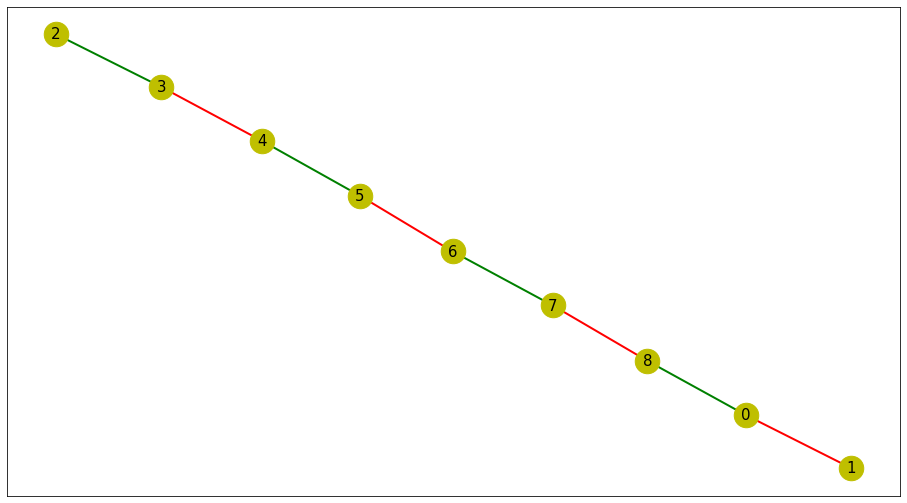

In [21]:
string = "x( r + r( + ) x*( + ) t2*( + ) )"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
draw_skeleton(skeleton_graph)

In [22]:
string = "x( r + r( + ) x*( + ) t2*( + ) )"
length_input_dict = {}
palette = "Plasma"

d = master_function(string, length_input_dict, palette)
d

[]
[['x', 'paired', '#f0f921', '#EDF194'], ['r', 'unhinged', '#fdb42f'], ['r', 'paired', '#ed7953', '#E8AE9B'], ['r*', 'paired', '#ed7953', '#E8AE9B'], ['x*', 'paired', '#cc4778', '#CC91A6'], ['x', 'paired', '#cc4778', '#CC91A6'], ['t2*', 'paired', '#9c179e', '#AE7FAF'], ['t2', 'paired', '#9c179e', '#AE7FAF'], ['x*', 'paired', '#f0f921', '#EDF194']]


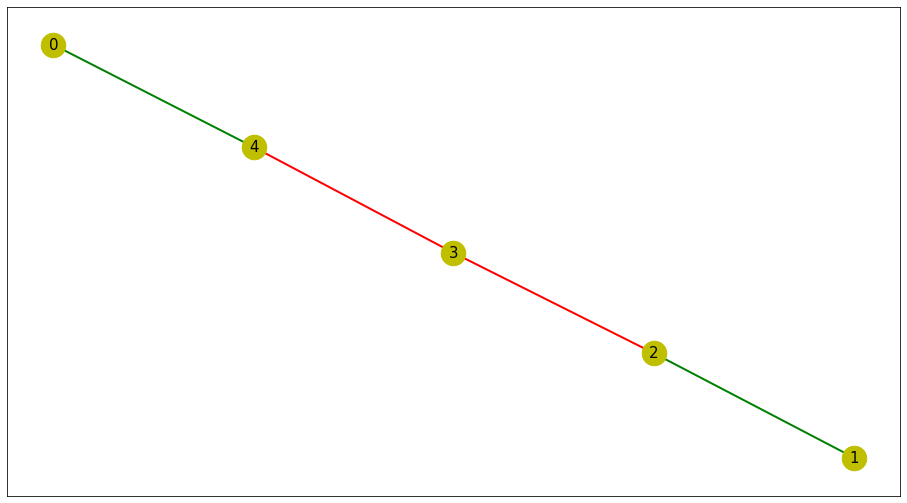

In [23]:
string = "a( + b( + ) c )"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
draw_skeleton(skeleton_graph)

In [24]:
string = "a( + b( + ) c )"
length_input_dict = {}
palette = "Plasma"

d = master_function(string, length_input_dict, palette)
d

[]
[['a', 'paired', '#f0f921', '#EDF194'], ['b', 'paired', '#fdb42f', '#F9DCA8'], ['b*', 'paired', '#fdb42f', '#F9DCA8'], ['c', 'ambiguous', '#ed7953'], ['a*', 'paired', '#f0f921', '#EDF194']]


In [25]:
string = "a( m1 b( + l1 ) m2 c( + l2 h2 ) m3 )"
length_input_dict = {0:30, 2:40}
palette = "Plasma"

d = master_function(string, length_input_dict, palette)
d

[[1, 10, 5]]
[[ 1.  0.  0.]
 [ 2.  0. 10.]
 [ 5.  0.  0.]
 [ 6.  0. 10.]
 [10.  0.  0.]
 [11.  0. 10.]]
[0, 1, 2, 4, 5, 6, 9, 10, 11] case 1
[[  1. 120.  10.]
 [  2. 120.  10.]
 [  5. 120.  10.]
 [  6. 120.  10.]
 [ 10. 120.  10.]
 [ 11. 120.  10.]]
[[  1. 120.  10.]
 [  2. 120.  10.]
 [  5. 120.  10.]
 [  6. 120.  10.]
 [ 10. 120.  10.]
 [ 11. 120.  10.]]
[['a', 'paired', '#f0f921', '#EDF194'], ['m1', 'multiloop', '#fdb42f'], ['b', 'paired', '#fdb42f', '#F9DCA8'], ['l1', 'unhinged', '#ed7953'], ['b*', 'paired', '#fdb42f', '#F9DCA8'], ['m2', 'multiloop', '#fdb42f'], ['c', 'paired', '#cc4778', '#CC91A6'], ['l2', 'ambiguous', '#9c179e'], ['h2', 'ambiguous', '#5c01a6'], ['c*', 'paired', '#cc4778', '#CC91A6'], ['m3', 'multiloop', '#fdb42f'], ['a*', 'paired', '#f0f921', '#EDF194']]
POINT (38.66025403784438 4.999999999999999)
[38.66025404  5.        ]


In [26]:
string = "a b c d"
length_input_dict = {}
palette = "Plasma"

d = master_function(string, length_input_dict, palette)
d

[]
[['a', 'unhinged', '#f0f921'], ['b', 'unhinged sequence', '#fdb42f'], ['c', 'unhinged sequence', '#ed7953'], ['d', 'unhinged sequence', '#cc4778']]


In [27]:
string = "@60 a b( hp1 ) @-60 c d( hp2 ) @-60 e f( hp3 ) @-60 g"
length_input_dict = {0:30, 1:30, 8:35}
palette = "Wong"

d = master_function(string, length_input_dict, palette)
d

[]
[['a', 'unhinged', '#000000'], ['b', 'paired', '#E69F00', '#EAC267'], ['hp1', 'hairpin loop', '#56B4E9'], ['b*', 'paired', '#E69F00', '#EAC267'], ['c', 'ambiguous', '#009E73'], ['d', 'paired', '#F0E442', '#E8E4A7'], ['hp2', 'hairpin loop', '#0072B2'], ['d*', 'paired', '#F0E442', '#E8E4A7'], ['e', 'ambiguous', '#D55E00'], ['f', 'paired', '#CC79A7', '#C7A8BA'], ['hp3', 'hairpin loop', '#000000'], ['f*', 'paired', '#CC79A7', '#C7A8BA'], ['g', 'unhinged', '#E69F00']]


In [52]:
string = "a b( c c1 d( hp ) e e1 ) g"
length_input_dict = {1:30, 2:25, 8:25}
palette = "Wong"

d = master_function(string, length_input_dict, palette)
d

[[2, 8, 7, 3]]
[[ 2.  0. 25.]
 [ 3.  0.  0.]
 [ 4.  0. 10.]
 [ 7.  0.  0.]
 [ 8.  0. 25.]
 [ 9.  0. 10.]]
[1, 2, 3, 4, 6, 7, 8, 9] case 1
[[  2.  120.   25. ]
 [  3.  120.   17.5]
 [  4.  120.   10. ]
 [  7.  120.   17.5]
 [  8.  120.   25. ]
 [  9.  120.   10. ]]
[[  2.         120.          25.        ]
 [  3.         120.          17.5       ]
 [  4.         120.          10.        ]
 [  7.         136.99608806  22.22048604]
 [  8.         103.00391194  25.        ]
 [  9.         120.          10.        ]]
[['a', 'unhinged', '#000000'], ['b', 'paired', '#E69F00', '#EAC267'], ['c', 'multiloop', '#56B4E9'], ['c1', 'multiloop', '#56B4E9'], ['d', 'paired', '#56B4E9', '#A5CCE2'], ['hp', 'hairpin loop', '#009E73'], ['d*', 'paired', '#56B4E9', '#A5CCE2'], ['e', 'multiloop', '#56B4E9'], ['e1', 'multiloop', '#56B4E9'], ['b*', 'paired', '#E69F00', '#EAC267'], ['g', 'ambiguous', '#F0E442']]
POINT (27.86062301897393 -49.34229295688283)
[ 27.86062302 -49.34229296]


In [48]:
string = "a b( c1 @-45 d( hp ) e1 ) g"
length_input_dict = {0:15,1:33}
palette = "Wong"

d = master_function(string, length_input_dict, palette)
d

[[2, 6]]
[[  2.   0.   0.]
 [  3. 135.  10.]
 [  6.   0.   0.]
 [  7.   0.  10.]]
[1, 2, 3, 5, 6, 7] case 1
[[  2.          75.           8.57142857]
 [  3.         135.          10.        ]
 [  6.          75.          12.        ]
 [  7.          75.          10.        ]]
[[  2.          75.           8.57142857]
 [  3.         135.          10.        ]
 [  6.          56.21422502  13.30840461]
 [  7.          93.78577498  10.        ]]
[['a', 'unhinged', '#000000'], ['b', 'paired', '#E69F00', '#EAC267'], ['c1', 'multiloop', '#56B4E9'], ['d', 'paired', '#56B4E9', '#A5CCE2'], ['hp', 'hairpin loop', '#009E73'], ['d*', 'paired', '#56B4E9', '#A5CCE2'], ['e1', 'multiloop', '#56B4E9'], ['b*', 'paired', '#E69F00', '#EAC267'], ['g', 'ambiguous', '#F0E442']]
POINT (21.2439553178296 -38.25936467366068)
[ 21.24395532 -38.25936467]


In [45]:
string = "@90 a( @120 b( c d( e ) f ) g h( i ) ) j"
length_input_dict = {0:35}
palette = "Wong"

d = master_function(string, length_input_dict, palette)
d

[[2, 6]]
[[  1. 120.  10.]
 [  8.   0.   0.]
 [  9.   0.  10.]
 [ 12.   0.  10.]]
[0, 1, 7, 8, 9, 11, 12] case 1
[[  1.         120.          10.        ]
 [  8.          80.          11.66666667]
 [  9.          80.          10.        ]
 [ 12.          80.          10.        ]]
[[  1.         120.          10.        ]
 [  8.          65.11751087  13.31660018]
 [  9.          94.88248913  10.        ]
 [ 12.          80.          10.        ]]
[[ 2.  0.  0.]
 [ 3.  0. 10.]
 [ 6.  0.  0.]
 [ 7.  0. 10.]]
[1, 2, 3, 5, 6, 7] case 1
[[ 2. 90. 10.]
 [ 3. 90. 10.]
 [ 6. 90. 10.]
 [ 7. 90. 10.]]
[[ 2. 90. 10.]
 [ 3. 90. 10.]
 [ 6. 90. 10.]
 [ 7. 90. 10.]]
[['a', 'paired', '#000000', '#BDBDBD'], ['b', 'paired', '#E69F00', '#EAC267'], ['c', 'multiloop', '#56B4E9'], ['d', 'paired', '#56B4E9', '#A5CCE2'], ['e', 'hairpin loop', '#009E73'], ['d*', 'paired', '#56B4E9', '#A5CCE2'], ['f', 'multiloop', '#56B4E9'], ['b*', 'paired', '#E69F00', '#EAC267'], ['g', 'bulgeloop', '#F0E442'], ['h', 'paired',

In [60]:
string = "@90 a( b( c d( e ) f ) g h( i ) ) j"
length_input_dict = {0:35}
palette = "Wong"

d = master_function(string, length_input_dict, palette)
d

[[2, 6]]
[[ 1.  0. 10.]
 [ 8.  0.  0.]
 [ 9.  0. 10.]
 [12.  0. 10.]]
[0, 1, 7, 8, 9, 11, 12] case 1
[[ 1. 90. 10.]
 [ 8. 90. 10.]
 [ 9. 90. 10.]
 [12. 90. 10.]]
[[ 1. 90. 10.]
 [ 8. 90. 10.]
 [ 9. 90. 10.]
 [12. 90. 10.]]
[[ 2.  0.  0.]
 [ 3.  0. 10.]
 [ 6.  0.  0.]
 [ 7.  0. 10.]]
[1, 2, 3, 5, 6, 7] case 1
[[ 2. 90. 10.]
 [ 3. 90. 10.]
 [ 6. 90. 10.]
 [ 7. 90. 10.]]
[[ 2. 90. 10.]
 [ 3. 90. 10.]
 [ 6. 90. 10.]
 [ 7. 90. 10.]]
[['a', 'paired', '#000000', '#BDBDBD'], ['b', 'paired', '#E69F00', '#EAC267'], ['c', 'multiloop', '#56B4E9'], ['d', 'paired', '#56B4E9', '#A5CCE2'], ['e', 'hairpin loop', '#009E73'], ['d*', 'paired', '#56B4E9', '#A5CCE2'], ['f', 'multiloop', '#56B4E9'], ['b*', 'paired', '#E69F00', '#EAC267'], ['g', 'bulgeloop', '#F0E442'], ['h', 'paired', '#0072B2', '#6595B1'], ['i', 'hairpin loop', '#D55E00'], ['h*', 'paired', '#0072B2', '#6595B1'], ['a*', 'paired', '#000000', '#BDBDBD'], ['j', 'unhinged', '#CC79A7']]
POINT (-21.25 40)
[-21.25  40.  ]


In [65]:
string = "a b( hp ) c @-90 d( + )"
length_input_dict = {2:35}
palette = "IBM"

d = master_function(string, length_input_dict, palette)
d

[]
[['a', 'unhinged', '#648FFF'], ['b', 'paired', '#785EF0', '#CAC1F3'], ['hp', 'hairpin loop', '#DC267F'], ['b*', 'paired', '#785EF0', '#CAC1F3'], ['c', 'ambiguous', '#FE6100'], ['d', 'paired', '#FFB000', '#F9E5B9'], ['d*', 'paired', '#FFB000', '#F9E5B9']]


In [32]:
string = "@30 a b( @-45 c( hp ) e )"
length_input_dict = {2:35}
palette = "IBM"

d = master_function(string, length_input_dict, palette)
d

[]
[[ 2. 45. 10.]
 [ 5.  0.  0.]
 [ 6.  0. 10.]]
[1, 2, 4, 5, 6] case 1
[[ 2.         45.         10.        ]
 [ 5.         67.5         8.33333333]
 [ 6.         67.5        10.        ]]
[[ 2.         45.         10.        ]
 [ 5.         67.5         7.65366865]
 [ 6.         67.5        10.        ]]
[['a', 'unhinged', '#648FFF'], ['b', 'paired', '#785EF0', '#CAC1F3'], ['c', 'paired', '#DC267F', '#DC9BBB'], ['hp', 'hairpin loop', '#FE6100'], ['c*', 'paired', '#DC267F', '#DC9BBB'], ['e', 'bulgeloop', '#FFB000'], ['b*', 'paired', '#785EF0', '#CAC1F3']]


In [47]:
string = "@-90 aa( i1 da( dl ) i2 aca( acl ) vr pa( pl ) i3 ) @0 c"
length_input_dict = {0:30, 2:20, 6:20, 10:25}
palette = "Plasma"

d = master_function(string, length_input_dict, palette)
d

[[1, 13, 5, 9]]
[[ 1.  0.  0.]
 [ 2.  0. 10.]
 [ 5.  0.  0.]
 [ 6.  0. 10.]
 [ 9.  0.  0.]
 [10.  0. 10.]
 [13.  0.  0.]
 [14.  0. 10.]]
[0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14] case 1
[[  1. 135.  10.]
 [  2. 135.  10.]
 [  5. 135.  10.]
 [  6. 135.  10.]
 [  9. 135.  10.]
 [ 10. 135.  10.]
 [ 13. 135.  10.]
 [ 14. 135.  10.]]
[[  1. 135.  10.]
 [  2. 135.  10.]
 [  5. 135.  10.]
 [  6. 135.  10.]
 [  9. 135.  10.]
 [ 10. 135.  10.]
 [ 13. 135.  10.]
 [ 14. 135.  10.]]
[['aa', 'paired', '#f0f921', '#EDF194'], ['i1', 'multiloop', '#fdb42f'], ['da', 'paired', '#fdb42f', '#F9DCA8'], ['dl', 'hairpin loop', '#ed7953'], ['da*', 'paired', '#fdb42f', '#F9DCA8'], ['i2', 'multiloop', '#fdb42f'], ['aca', 'paired', '#cc4778', '#CC91A6'], ['acl', 'hairpin loop', '#9c179e'], ['aca*', 'paired', '#cc4778', '#CC91A6'], ['vr', 'multiloop', '#fdb42f'], ['pa', 'paired', '#5c01a6', '#9C78B9'], ['pl', 'hairpin loop', '#0d0887'], ['pa*', 'paired', '#5c01a6', '#9C78B9'], ['i3', 'multiloop', '#fdb42f'], ['aa*

In [34]:
string = "@-45 d1S T2 @-135 b( a( t2( + ) ) c*( t1* + ) )"
length_input_dict = {}
palette = "Magma"

d = master_function(string, length_input_dict, palette)
d

[]
[[ 3.  0. 10.]
 [ 7.  0. 10.]
 [10.  0. 10.]]
[2, 3, 6, 7, 9, 10] case 4
[['d1S', 'unhinged', '#fcfdbf'], ['T2', 'unhinged sequence', '#fe9f6d'], ['b', 'paired', '#de4968', '#DCA6B1'], ['a', 'paired', '#8c2981', '#BBA0B8'], ['t2', 'paired', '#3b0f70', '#AA93C5'], ['t2*', 'paired', '#3b0f70', '#AA93C5'], ['a*', 'paired', '#8c2981', '#BBA0B8'], ['c*', 'paired', '#000004', '#A9A9A9'], ['t1*', 'ambiguous', '#fcfdbf'], ['c', 'paired', '#000004', '#A9A9A9'], ['b*', 'paired', '#de4968', '#DCA6B1']]


In [35]:
string = "a( @-75 b( hp ) @-75 c( + ) bu )"
length_input_dict = {0:30, 1:30, 4:30}
palette = "IBM"

d = master_function(string, length_input_dict, palette)
d

[]
[[ 1. 75. 10.]
 [ 4. 75. 10.]
 [ 6.  0.  0.]
 [ 7.  0. 10.]]
[0, 1, 3, 4, 5, 6, 7] case 1
[[  1.         75.         10.       ]
 [  4.         75.         10.       ]
 [  6.        105.          8.0952381]
 [  7.        105.         10.       ]]
[[  1.         75.         10.       ]
 [  4.         75.         10.       ]
 [  6.        105.          4.8236191]
 [  7.        105.         10.       ]]
[['a', 'paired', '#648FFF', '#BACCFB'], ['b', 'paired', '#785EF0', '#CAC1F3'], ['hp', 'hairpin loop', '#DC267F'], ['b*', 'paired', '#785EF0', '#CAC1F3'], ['c', 'paired', '#FE6100', '#F1C2A6'], ['c*', 'paired', '#FE6100', '#F1C2A6'], ['bu', 'bulgeloop', '#FFB000'], ['a*', 'paired', '#648FFF', '#BACCFB']]


In [36]:
string = "a( b( hp ) c( + ) bu )"
length_input_dict = {0:30,1:30,4:30}
palette = "Magma"

d = master_function(string, length_input_dict, palette)
d

[]
[[ 1.  0. 10.]
 [ 4.  0. 10.]
 [ 6.  0.  0.]
 [ 7.  0. 10.]]
[0, 1, 3, 4, 5, 6, 7] case 1
[[ 1. 90. 10.]
 [ 4. 90. 10.]
 [ 6. 90. 10.]
 [ 7. 90. 10.]]
[[ 1. 90. 10.]
 [ 4. 90. 10.]
 [ 6. 90. 10.]
 [ 7. 90. 10.]]
[['a', 'paired', '#fcfdbf', '#FFFFE8'], ['b', 'paired', '#fe9f6d', '#F7C9B1'], ['hp', 'hairpin loop', '#de4968'], ['b*', 'paired', '#fe9f6d', '#F7C9B1'], ['c', 'paired', '#8c2981', '#BBA0B8'], ['c*', 'paired', '#8c2981', '#BBA0B8'], ['bu', 'bulgeloop', '#3b0f70'], ['a*', 'paired', '#fcfdbf', '#FFFFE8']]


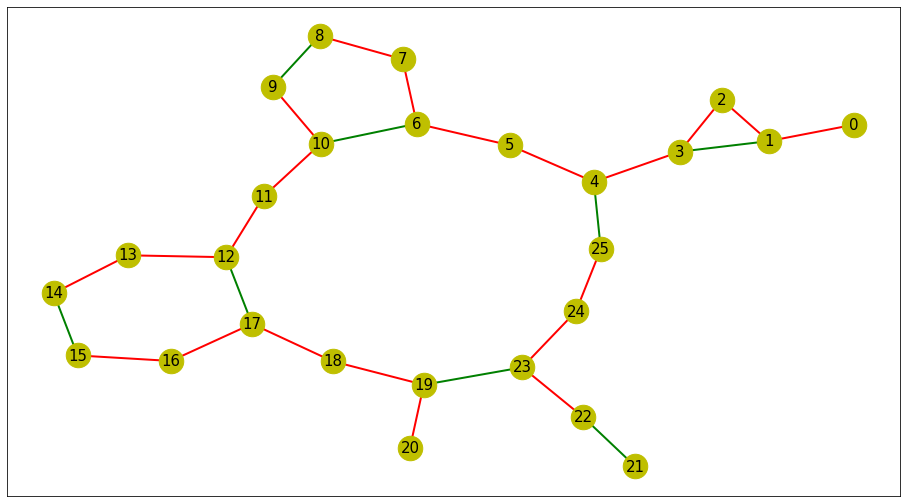

In [37]:
string = "a b( c ) d( e f( g h( + ) ) i j( k l( + ) m ) n o( p + q( + ) ) r )"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
draw_skeleton(skeleton_graph)

In [38]:
string = "@180 a b( c ) @-30 d( e f( g h( + ) ) i j( k l( + ) m ) n o( p + q( + ) ) r )"
length_input_dict = {0:40}
palette = "IBM"

d = master_function(string, length_input_dict, palette)
d

[[16, 13], [5, 24, 11, 18]]
[[13.  0.  0.]
 [14.  0. 10.]
 [16.  0.  0.]
 [17.  0. 10.]]
[12, 13, 14, 15, 16, 17] case 1
[[13. 90. 10.]
 [14. 90. 10.]
 [16. 90. 10.]
 [17. 90. 10.]]
[[13. 90. 10.]
 [14. 90. 10.]
 [16. 90. 10.]
 [17. 90. 10.]]
[[ 5.  0.  0.]
 [ 6.  0. 10.]
 [11.  0.  0.]
 [12.  0. 10.]
 [18.  0.  0.]
 [19.  0. 10.]
 [24.  0.  0.]
 [25.  0. 10.]]
[4, 5, 6, 10, 11, 12, 17, 18, 19, 23, 24, 25] case 1
[[  5. 135.  10.]
 [  6. 135.  10.]
 [ 11. 135.  10.]
 [ 12. 135.  10.]
 [ 18. 135.  10.]
 [ 19. 135.  10.]
 [ 24. 135.  10.]
 [ 25. 135.  10.]]
[[  5. 135.  10.]
 [  6. 135.  10.]
 [ 11. 135.  10.]
 [ 12. 135.  10.]
 [ 18. 135.  10.]
 [ 19. 135.  10.]
 [ 24. 135.  10.]
 [ 25. 135.  10.]]
[[ 7.  0.  0.]
 [ 8.  0. 10.]
 [10.  0. 10.]]
[6, 7, 8, 9, 10] case 1
[[ 7. 60. 10.]
 [ 8. 60. 10.]
 [10. 60. 10.]]
[[ 7. 60. 10.]
 [ 8. 60. 10.]
 [10. 60. 10.]]
[['a', 'unhinged', '#648FFF'], ['b', 'paired', '#785EF0', '#CAC1F3'], ['c', 'hairpin loop', '#DC267F'], ['b*', 'paired', '#785EF0',

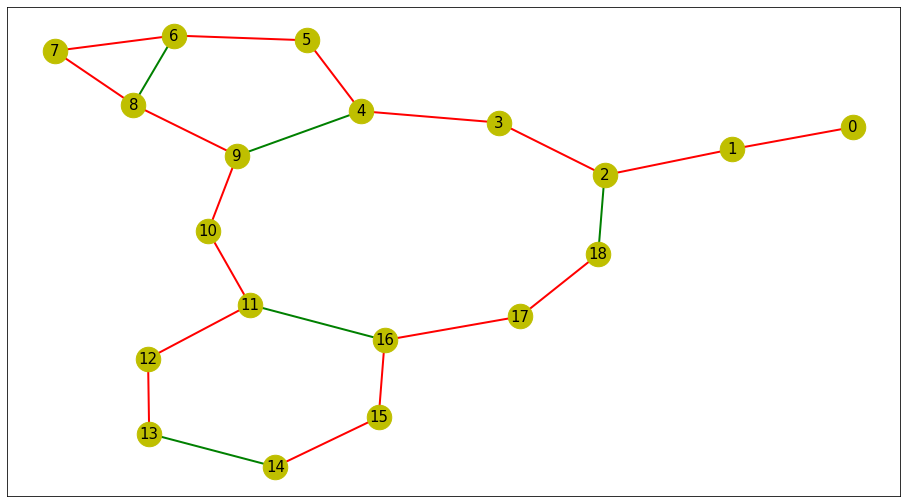

In [39]:
string = "h1 h2 a( m1 b( c d( hp1 ) ) m2 e( i1 f( + ) i2 ) m3 )"
dom_raw_list, struct_info_array, paired_dict, name_final_lol = comprehend_string(string)
skeleton_graph = create_skeleton(dom_raw_list, paired_dict, name_final_lol)
draw_skeleton(skeleton_graph)

In [40]:
string = "h1 h2 a( m1 b( c d( hp1 ) ) m2 e( i1 f( + ) i2 ) m3 )"
length_input_dict = {2:40}
palette = "IBM"

d = master_function(string, length_input_dict, palette)
d

[[15, 12], [3, 17, 10]]
[[12.  0.  0.]
 [13.  0. 10.]
 [15.  0.  0.]
 [16.  0. 10.]]
[11, 12, 13, 14, 15, 16] case 1
[[12. 90. 10.]
 [13. 90. 10.]
 [15. 90. 10.]
 [16. 90. 10.]]
[[12. 90. 10.]
 [13. 90. 10.]
 [15. 90. 10.]
 [16. 90. 10.]]
[[ 3.  0.  0.]
 [ 4.  0. 10.]
 [10.  0.  0.]
 [11.  0. 10.]
 [17.  0.  0.]
 [18.  0. 10.]]
[2, 3, 4, 9, 10, 11, 16, 17, 18] case 1
[[  3. 120.  10.]
 [  4. 120.  10.]
 [ 10. 120.  10.]
 [ 11. 120.  10.]
 [ 17. 120.  10.]
 [ 18. 120.  10.]]
[[  3. 120.  10.]
 [  4. 120.  10.]
 [ 10. 120.  10.]
 [ 11. 120.  10.]
 [ 17. 120.  10.]
 [ 18. 120.  10.]]
[[ 5.  0.  0.]
 [ 6.  0. 10.]
 [ 9.  0. 10.]]
[4, 5, 6, 8, 9] case 1
[[ 5. 60. 10.]
 [ 6. 60. 10.]
 [ 9. 60. 10.]]
[[ 5. 60. 10.]
 [ 6. 60. 10.]
 [ 9. 60. 10.]]
[['h1', 'unhinged', '#648FFF'], ['h2', 'unhinged sequence', '#785EF0'], ['a', 'paired', '#DC267F', '#DC9BBB'], ['m1', 'multiloop', '#FE6100'], ['b', 'paired', '#FE6100', '#F1C2A6'], ['c', 'bulgeloop', '#FFB000'], ['d', 'paired', '#648FFF', '#BACCFB'],

In [59]:
string = "a( b( + ) )"
length_input_dict = {}
palette = "IBM"

d = master_function(string, length_input_dict, palette)
d

[]
[['a', 'paired', '#648FFF', '#BACCFB'], ['b', 'paired', '#785EF0', '#CAC1F3'], ['b*', 'paired', '#785EF0', '#CAC1F3'], ['a*', 'paired', '#648FFF', '#BACCFB']]


In [42]:
string = "r b( g r b( l ) y r b( g + l ) y r b( g + l ) y l ) y"
length_input_dict = {1:30, 4:30, 9:30, 15:30}
palette = "Magma"

d = master_function(string, length_input_dict, palette)
d

[[2, 20, 7, 3, 13, 8, 19, 14]]
[[ 2.  0.  0.]
 [ 3.  0.  0.]
 [ 4.  0. 10.]
 [ 7.  0.  0.]
 [ 8.  0.  0.]
 [ 9.  0. 10.]
 [13.  0.  0.]
 [14.  0.  0.]
 [15.  0. 10.]
 [19.  0.  0.]
 [20.  0.  0.]
 [21.  0. 10.]]
[1, 2, 3, 4, 6, 7, 8, 9, 12, 13, 14, 15, 18, 19, 20, 21] case 1
[[  2. 150.  10.]
 [  3. 150.  10.]
 [  4. 150.  10.]
 [  7. 150.  10.]
 [  8. 150.  10.]
 [  9. 150.  10.]
 [ 13. 150.  10.]
 [ 14. 150.  10.]
 [ 15. 150.  10.]
 [ 19. 150.  10.]
 [ 20. 150.  10.]
 [ 21. 150.  10.]]
[[  2. 150.  10.]
 [  3. 150.  10.]
 [  4. 150.  10.]
 [  7. 150.  10.]
 [  8. 150.  10.]
 [  9. 150.  10.]
 [ 13. 150.  10.]
 [ 14. 150.  10.]
 [ 15. 150.  10.]
 [ 19. 150.  10.]
 [ 20. 150.  10.]
 [ 21. 150.  10.]]
[['r', 'unhinged', '#fcfdbf'], ['b', 'paired', '#fe9f6d', '#F7C9B1'], ['g', 'multiloop', '#de4968'], ['r', 'multiloop', '#de4968'], ['b', 'paired', '#de4968', '#DCA6B1'], ['l', 'hairpin loop', '#8c2981'], ['b*', 'paired', '#de4968', '#DCA6B1'], ['y', 'multiloop', '#de4968'], ['r', 'multilo